In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
from ipyleaflet import Map, Heatmap, basemaps, Marker

**Загрузка данных**

Агрегированные данные за май 2016

In [2]:
data = pd.read_pickle('./TAXI DATA/PICKLES/2016_05.pkl')

In [3]:
data.head()

,date and time,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,2016-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-05-04 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-05-04 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-05-05 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-05-05 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Таблица id и координат ячеек

In [4]:
table = pd.read_csv('regions.csv', sep = ';')

In [5]:
table.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [6]:
table.shape

(2500, 5)

Число ячеек, из которых не было совершено ни одной поездки в мае.

In [7]:
travels_summ = data.sum(axis=0)
(travels_summ==0).sum()

1283

**Границы и координаты**

Координаты Empire State Buildig

In [8]:
# Границы изучаемой карты поездок
min_long = -74.25559
max_long = -73.70001
min_lat = 40.49612
max_lat = 40.91553

# Координаты Empire State Building
empire_location = (40.748306, -73.985756)
empire_long = -73.985756
empire_lat = 40.748306

# Координаты статуи свободы
liberty_location = (40.689167, -74.044583)

**Визуализация карты Нью-Йорка**

**Статическая карта**

Общее число поездок за месяц из каждой ячейки

In [9]:
summ = data.sum(axis = 0).values

Координаты ячеек для тепловой карты

In [10]:
longs = np.unique(table[['west', 'east']].values)
lats = np.unique(table[['north', 'south']].values)

lon, lat = np.meshgrid(longs, lats)

Отобразим карту и тепловое распределение

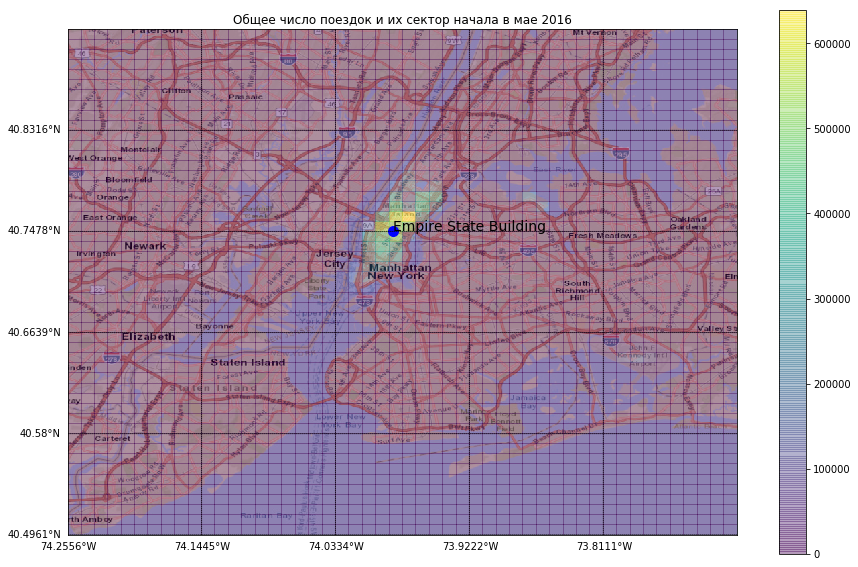

In [11]:
plt.figure(figsize = (15, 10))

m = Basemap(
            llcrnrlon = min_long, llcrnrlat = min_lat, urcrnrlon = max_long, urcrnrlat = max_lat,
            #llcrnrlon = np.min(longs), llcrnrlat = np.min(lats), urcrnrlon = np.max(longs), urcrnrlat = np.max(lats),
            resolution = 'f',
            projection = 'lcc', 
            lat_0 = (max_lat + max_lat)/2.0, lon_0 = (min_long + max_long)/2,
            epsg=4326)
#http://server.arcgisonline.com/arcgis/rest/services
#http://spatialreference.org/


m.arcgisimage(service='World_Street_Map', xpixels=1000, epsg=4269)

# Метка
x, y = m(empire_long, empire_lat)
m.plot(x, y, 'bo', markersize = 10)
plt.text(x, y, 'Empire State Building', fontsize = 14)


#Тепловая карта
m.pcolormesh(lon, lat, summ.reshape(50, 50).transpose(), latlon = True, alpha = 0.4)
plt.colorbar()


# labels = [left,right,top,bottom]
parallels = np.arange(min_lat, max_lat, (max_lat - min_lat)/5.0)
meridians = np.arange(min_long, max_long, (max_long - min_long)/5.0)
m.drawparallels(parallels, labels = [True, False, False, False])
m.drawmeridians(meridians, labels = [False, False, False, True])

plt.title(u'Общее число поездок и их сектор начала в мае 2016')

plt.show()

**Интерактивная карта**

Отобразим карту и отметим статую свободы

In [12]:
import folium 
from folium import plugins

In [13]:
folium_data = pd.DataFrame(zip(table['north'].values, table['west'].values, data.mean(axis = 0).values), 
                           columns = ['lat', 'lon', 'mean'])

In [14]:
folium_data.head()

,lat,lon,mean
0,40.504508,-74.25559,0.0
1,40.512896,-74.25559,0.0
2,40.521285,-74.25559,0.0
3,40.529673,-74.25559,0.0
4,40.538061,-74.25559,0.0


In [15]:
m = folium.Map(location = liberty_location, zoom_start = 10, control_scale = True, attr='USGS style')
folium.Marker(liberty_location, 'Statue of Liberty').add_to(m)
m.add_child(plugins.HeatMap(folium_data[folium_data['mean']>=5].values, radius = 10))
m


Число ячеек, где среднее число поездок за месяц больше 5:

In [16]:
print (data.mean(axis = 0)>5).sum()

102
